Name: Sudhina D

Batch: R3

Date: 12-03-2023

Experiment Name:Mini Project: Credit card fraud detection using autoencoder

## Problem statement
The challenge is to recognize fraudulent credit card transactions so that the customers of credit card companies are not charged for items that they did not purchase.

Main challenges involved in credit card fraud detection are:
Enormous Data is processed every day and the model build must be fast enough to respond to the scam in time. Imbalanced Data i.e most of the transactions (99.8%) are not fraudulent which makes it really hard for detecting the fraudulent ones Data availability as the data is mostly private. Misclassified Data can be another major issue, as not every fraudulent transaction is caught and reported. Adaptive techniques used against the model by the scammers.

To overcome these:-
The model used must be simple and fast enough to detect the anomaly and classify it as a fraudulent transaction as quickly as possible. For protecting the privacy of the user the dimensionality of the data can be reduced. A more trustworthy source must be taken which double-check the data, at least for training the model.

Dataset

The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Reference link :https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Autoencoders and their use

Autoencoders are a type of neural network that takes an input (e.g. image, dataset), boils that input down to core features, and reverses the process to recreate the input. Although it may sound pointless to feed in input just to get the same thing out, it is in fact very useful for a number of applications. The key here is that the autoencoder boils down (encodes) the input into some key features that it determines in an unsupervised manner. Hence the name "autoencoder" — it automatically encodes the input.

It is the assumption in using autoencoders that fraud or anomalies will suffer from a detectably high reconstruction error.

In [1]:
# import packages
# matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

In [2]:
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75)
sns.set_palette(sns.xkcd_palette(col_list))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing data

The data contains 284,807 European credit card transactions that occurred over two days with 492 fraudulent transactions. Everything except the time and amount has been reduced by a Principle Component Analysis (PCA) for privacy concerns.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/DNNSP LAB/creditcard.csv")

In [5]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
# No of null values in dataset
df.isnull().values.sum()

0

Indeed the data seems to be cleaned and loaded as we expect. Now we want to check if we have the expected number of normal and fraudulent rows of data. We will simply pull the "Class" column and count the number of normal (0) and fraud (1) rows.

In [8]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

The counts are as expected (284,315 normal transactions and 492 fraud transactions). As is typical in fraud and anomaly detection in general, this is a very unbalanced dataset.

# Exploratory Data Analysis

## Balance of Data Visualization

Let's get a visual confirmation of the unbalanced data in this fraud dataset.

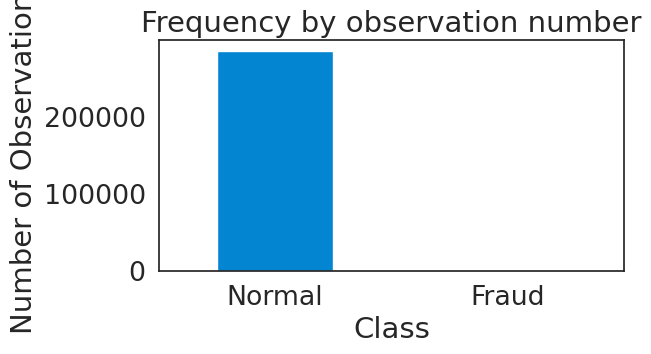

In [11]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(6, 3))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

# Summary Statistics of the Transaction Amount Data

We will cut up the dataset into two data frames, one for normal transactions and the other for fraud.

In [12]:
normal_df = df[df['Class']==0]
fraud_df = df[df['Class']==1]

In [13]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [14]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Although the mean is a little higher in the fraud transactions, it is certainly within a standard deviation and so is unlikely to be easy to discriminate in a highly precise manner between the classes with pure statistical methods.

# Visual Exploration of the Transaction Amount Data

In anomaly detection datasets it is common to have the areas of interest "washed out" by abundant data. In this dataset, a lot of low-value transactions that will be generally uninteresting (buying cups of coffee, lunches, etc). This abundant data is likely to wash out the rest of the data, so looking at transactions which are $200+

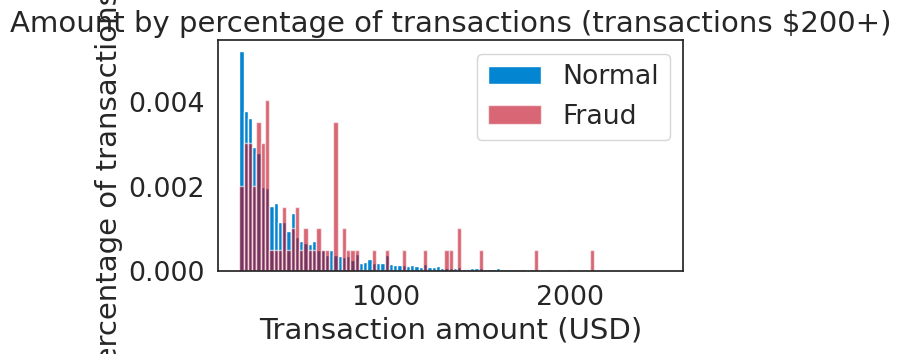

In [16]:
#plot of high value transactions
bins = np.linspace(200, 2500, 100)
plt.figure(figsize=(6, 3))
plt.hist(normal_df.Amount, bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200+)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

Since the fraud cases are relatively few in number compared to bin size, we see the data looks predictably more variable. In the long tail, especially, we are likely observing only a single fraud transaction. It would be hard to differentiate fraud from normal transactions by transaction amount alone.

## Visual Exploration of the Data by Hour

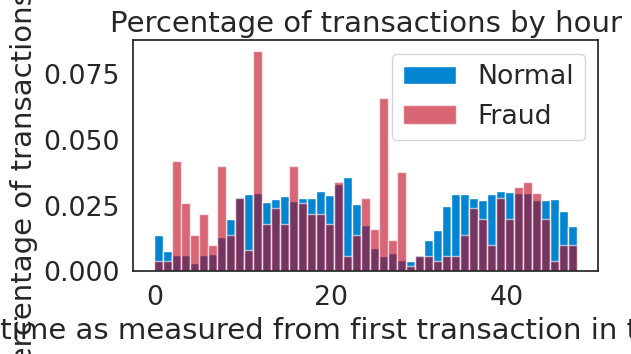

In [18]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(6, 3))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
# plt.hist((df.Time/(60*60)),bins)
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1am. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, I am assuming those time correspond to nighttime for this dataset. If this is true, fraud tends to occur at higher rates during the night. Statistical tests could be used to give evidence for this fact, but are not in the scope of this article. Again, however, the potential time offset between normal and fraud transactions is not enough to make a simple, precise classifier.

# Visual Exploration of Transaction Amount vs. Hour

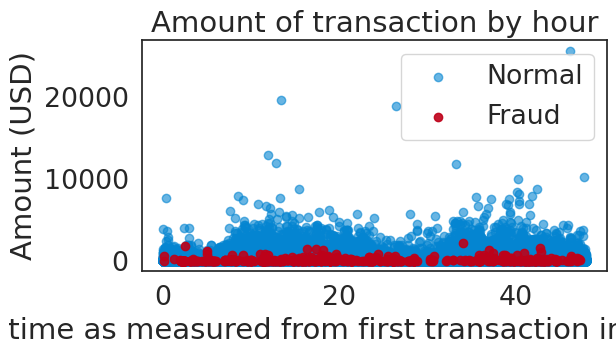

In [19]:
plt.figure(figsize=(6, 3))
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

# Model Setup: Basic Autoencoder

Now that more simplistic methods are not proving that useful, we are justified in exploring our autoencoder to see if it does a little better.

# Normalize and Scale Data

Both time and amount have very different magnitudes, which will likely result in the large magnitude value "washing out" the small magnitude value. It is therefore common to scale the data to similar magnitudes. As most of the data (other than 'time' and 'amount') result from the product of a PCA analysis. The PCA done on the dataset transformed it into standard-normal form. I will do the same to the 'time' and 'amount' columns.

In [20]:
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

# Dividing Training and Test Set

Now we split the data into training and testing sets according to the percentage and with a random seed we wrote at the beginning of the code.

In [21]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [22]:
nb_epoch = 50
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

# Creating The Model

# Autoencoder Layer Structure and Parameters

Autoencoder has symmetric encoding and decoding layers that are "dense". We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [23]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Model Training and Logging

Below is where we set up the actual run including checkpoints and the tensorboard.

In [24]:
# Configure the learning process, by compiling the model
autoencoder.compile(optimizer='adam',
                    metrics=['accuracy'],
                    loss='mean_squared_error')

# Saving the model
cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                     save_best_only=True,
                     verbose=0)

# TensorBoard basic visualizations.
# This callback writes a log for TensorBoard, 
# which allows you to visualize dynamic graphs of your training and test metrics
tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)

# Starts training
# autoencoder: same training(x) and target data(y)
# validation_data: tuple (x_val, y_val) on which 
# to evaluate the loss and any model metrics at the end of each epoch.

# History.history attribute is a record of training loss values 
# and metrics values at successive epochs.
history = autoencoder.fit(x=train_x, y=train_x,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_x, test_x),
                          verbose=1,
                          callbacks=[cp, tb]).history

Epoch 1/50
1778/1778 [==============================] - 10s 4ms/step - loss: 0.7557 - accuracy: 0.4966 - val_loss: 0.6988 - val_accuracy: 0.5860
Epoch 2/50
1778/1778 [==============================] - 6s 3ms/step - loss: 0.6401 - accuracy: 0.5957 - val_loss: 0.6530 - val_accuracy: 0.5995
Epoch 3/50
1778/1778 [==============================] - 5s 3ms/step - loss: 0.6090 - accuracy: 0.6150 - val_loss: 0.6320 - val_accuracy: 0.6283
Epoch 4/50
1778/1778 [==============================] - 7s 4ms/step - loss: 0.5922 - accuracy: 0.6293 - val_loss: 0.6214 - val_accuracy: 0.6257
Epoch 5/50
1778/1778 [==============================] - 7s 4ms/step - loss: 0.5842 - accuracy: 0.6320 - val_loss: 0.6148 - val_accuracy: 0.6367
Epoch 6/50
1778/1778 [==============================] - 6s 4ms/step - loss: 0.5788 - accuracy: 0.6359 - val_loss: 0.6103 - val_accuracy: 0.6340
Epoch 7/50
1778/1778 [==============================] - 8s 4ms/step - loss: 0.5743 - accuracy: 0.6403 - val_loss: 0.6062 - val_accuracy

In [25]:
autoencoder = load_model('autoencoder_fraud.h5')

# Model Testing/ Evaluation

### Model Loss
The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.

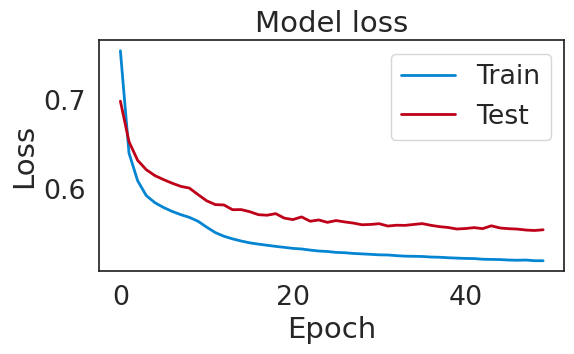

In [28]:
plt.figure(figsize=(6, 3))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

## Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below:

In [29]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

1781/1781 [==============================] - 5s 3ms/step


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.552829,0.002019
std,3.071132,0.044887
min,0.025912,0.000000
25%,0.143694,0.000000
50%,0.236774,0.000000
75%,0.405629,0.000000
max,196.755011,1.000000


## ROC Curve Check
Receiver operating characteristic curves are an expected output of most binary classifiers. Since we have an imbalanced data set they are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.

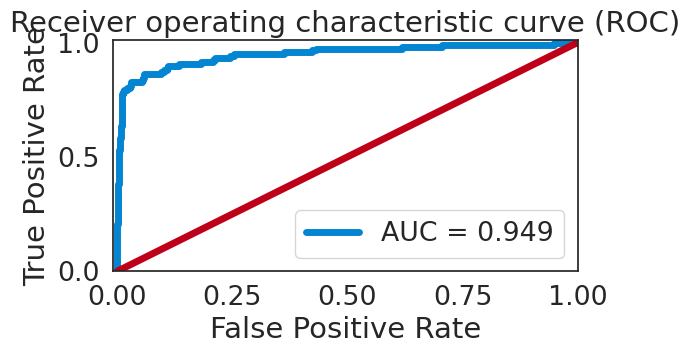

In [31]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(6, 3))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Recall vs. Precision Thresholding

Now let's look at recall vs. precision to see the trade-off between the two.

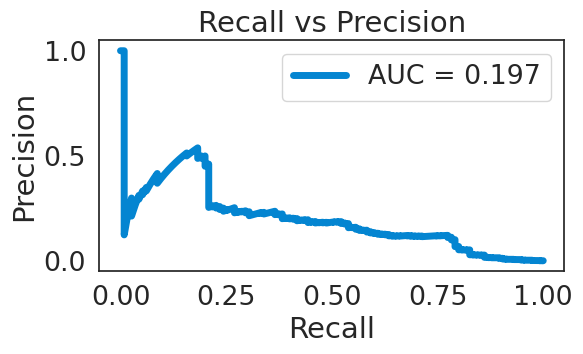

In [32]:
# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(6, 3))
plt.plot(recall_rt, precision_rt, linewidth=5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

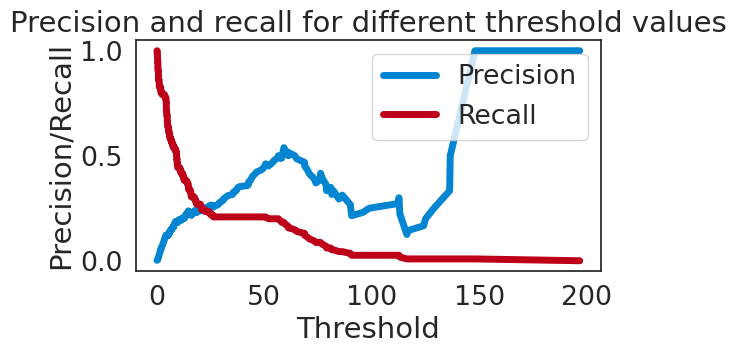

In [33]:
plt.figure(figsize=(6, 3))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Reconstruction Error vs Threshold Check

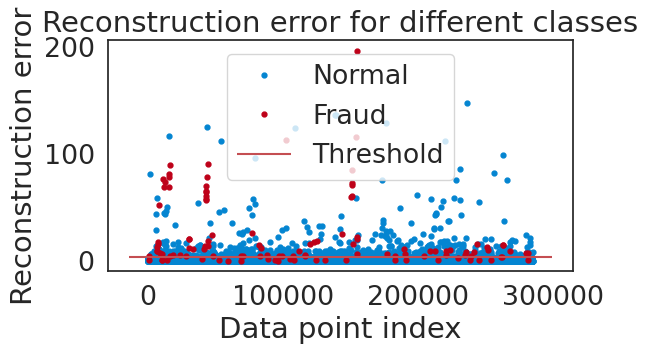

In [35]:
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(6, 3))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Confusion Matrix

Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision.

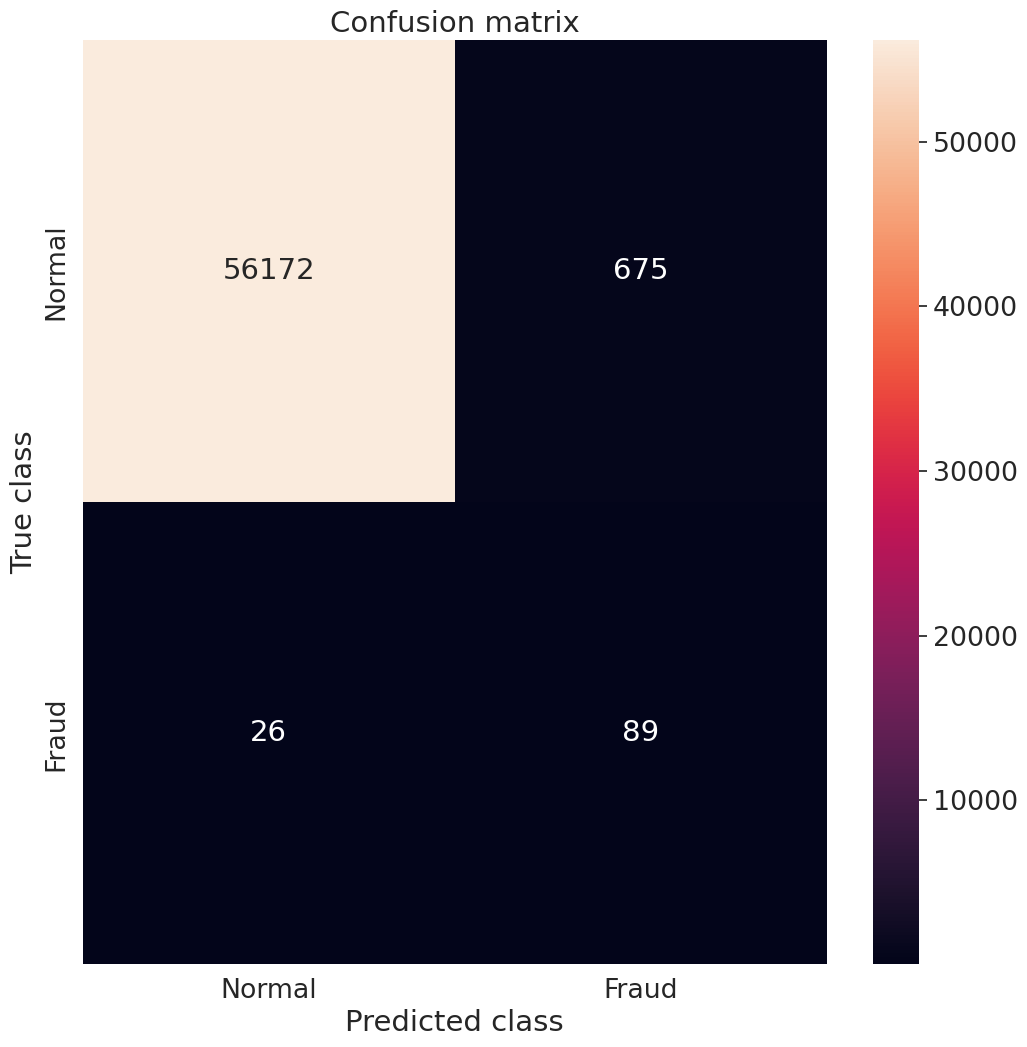

In [36]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# CONCLUSION

Through this miniproject, I was able to learn and implement an autoencoder based credit card fraud detection model. By overcoming the technical challenges of the project, I was able to gain a better understanding on architectural concepts and through the analysis of the model, I learned different concepts, their practical implementations and utilities. 

Following were the major takeaways from the project.

i.	Learned about datasets, creation, splitting and utilizations for the training purposes.

ii.	 Deeper insights on Neural Network architecture, could model and implement a design for solving the technical problem.

iii.	Knowledge on different activation functions, cost functions, optimisation algorithms and implementations for model training and analysis.

iv.	 Practical knowledge on model training and validation using the dataset.

v.	 Understanding different learning accuracy and loss plots and analysis of trained model using these.

vi.	 Use of test data and evaluation of the trained model using test data.

vii.	Concepts of different evaluation metrics and analysis of the performance using these.

viii.	 Indepth knowledge on autoencoder modelling, training and evaluation

x.	Deeper insights on encoder decoder model, attention mechanism and their training and evaluation methods.

xi.	 Practice on coding for implementing technical concepts.

As a result of overcoming technical challenges with possible measures, the model was able to be designed successfully. The model was able to colorize  random input images and it shows that the model is correctly trained to solve the problem.
